<h1 style="font-size:3rem;color:orange;">Jupyter Notebook</h1>

# Python Tutorial

In [384]:
import pandas as pd
import os
import requests
from datetime import datetime, date, timedelta
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets
from IPython.display import display, clear_output
import math
import urllib.request, json 

In [393]:
path_to_json = r'C:\Users\arthu\Projetos'
json_files = [pos_json for pos_json in os.listdir(path_to_json) if pos_json.endswith('.json')]
jsons_data = pd.DataFrame(columns=['contract', 'emission_price', 'start_date', 'index', 'spread', 'schedules'])

print(json_files)
print()
print(jsons_data)
print()

for i, js in enumerate(json_files):
    with open(os.path.join(path_to_json, js)) as json_file:
        json_text = json.load(json_file)
        contract = json_text['contract']
        emission_price = json_text['emission_price']
        start_date = json_text['start_date']
        index = json_text['index']
        spread = json_text['spread']
        schedules = json_text['schedules']
        jsons_data.loc[i] = [contract, emission_price, start_date, index, spread, schedules]

jsons_data

['contratoA.json', 'contratoB.json', 'contratoC.json', 'contratoD.json', 'contratoE.json', 'contratoF.json', 'contratoG.json']

Empty DataFrame
Columns: [contract, emission_price, start_date, index, spread, schedules]
Index: []



,contract,emission_price,start_date,index,spread,schedules
0,A,1000,2018-01-02,PRE,0.050000,"[{'due_date': '2025-08-20', 'amount': 1}]"
1,B,500,2019-10-07,PRE,0.070000,"[{'due_date': '2020-01-31', 'amount': 0.2}, {'..."
2,C,10000,2020-03-02,PRE,0.120000,"[{'due_date': '2020-06-01', 'amount': 0.1}, {'..."
3,D,2000,2015-08-17,PRE,0.120000,"[{'due_date': '2018-08-15', 'amount': 0.1}, {'..."
4,E,1,2020-06-22,PRE,0.120000,"[{'due_date': '2023-06-20', 'amount': 0.25}, {..."
5,ABEV11,1000000,2015-11-03,PRE,0.144760,"[{'due_date': '2021-10-30', 'amount': 1}]"
6,AGAU21,10000,2020-02-03,PRE,0.124519,"[{'due_date': '2026-01-10', 'amount': 1}]"


Dropdown(description='Selecione um contrato', index=1, options=('contratoA.json', 'contratoB.json', 'contratoC…

DatePicker(value=datetime.datetime(2020, 12, 10, 0, 0), description='Selecione a data de calculo')

Dropdown(options=('Calular PU de Operação (inserir taxa)', 'Calcular taxa (inserir PU de Operação)'), value='C…

Text(value='1', placeholder='Taxa (%) / PU de Operação')

Button(description='GO', style=ButtonStyle())

PU Par = 307.419961
PU de Operação = 223.728565


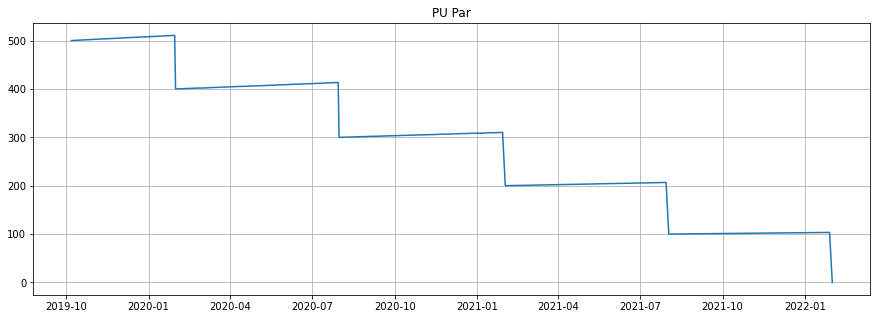

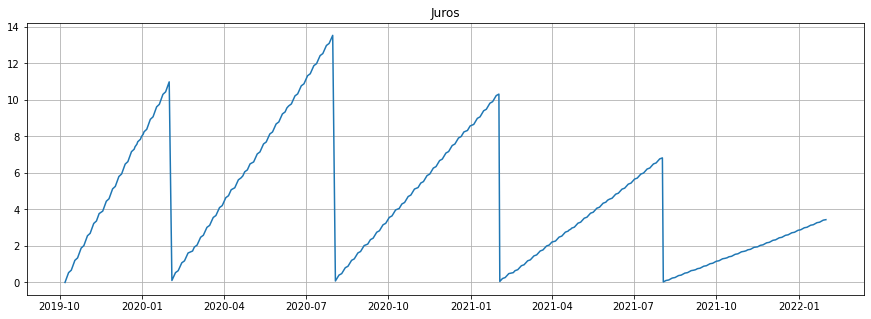

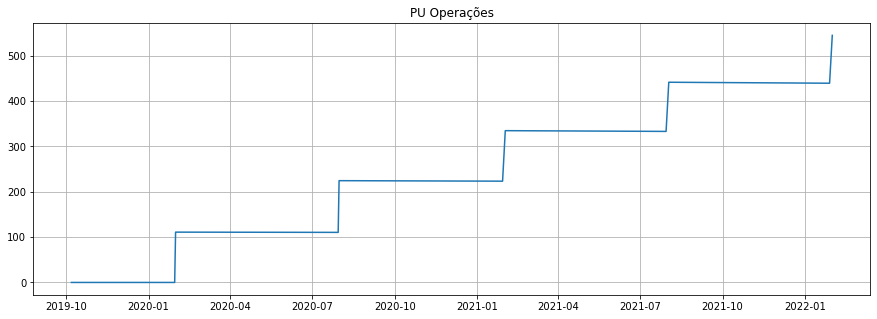

In [374]:
dropdownContratos = widgets.Dropdown(description='Selecione um contrato', options=json_files)
dataCalculo = widgets.DatePicker(description='Selecione a data de calculo',disabled=False)
dropdownMetodo = widgets.Dropdown(placeholder='Selecionar método', options=['Calular PU de Operação (inserir taxa)','Calcular taxa (inserir PU de Operação)'])
btn = widgets.Button(description='GO')
valor = widgets.Text(placeholder='Taxa (%) / PU de Operação',disabled=False)

dropdownContratos.value = 'contratoB.json'
valor.value = '1'
dataCalculo.value = datetime.fromisoformat('2020-12-10')

display(dropdownContratos)
display(dataCalculo)
display(dropdownMetodo)
display(valor)
display(btn)

def btn_eventhandler(obj):
    if valor.value == "":
        return
    if dropdownMetodo.value == 'Calular PU de Operação (inserir taxa)':
        GO()
        
btn.on_click(btn_eventhandler)

In [373]:
def GO():
    dateparse = lambda x: datetime.strptime(x, '%Y-%m-%d')

    df = pd.read_csv('https://raw.githubusercontent.com/arthuryukio/desafio_ps/main/feriados.csv', parse_dates=['Data'], date_parser=dateparse)
    
#     df = pd.read_csv('feriados.csv', parse_dates=['Data'], date_parser=dateparse)

    contrato = jsons_data.loc[json_files.index(dropdownContratos.value)]

    idContrato = contrato[0]

    VNE = contrato[1]
    VNA = VNE

    dataEmiss = datetime.strptime(contrato[2], '%Y-%m-%d').date()

    sp = contrato[4]

    taxaNeg = np.float64(valor.value)/100

    dueDates = contrato[5]
    duTemp = 0;

    PUPars = []

    Js = []
    datas = []
    amortizacao = []
    VNAs = []
    dus = []
    PUOperacaos = []

    du = 0
    A = 0
    J = 0
    jurosTotal = 0

    for n in range(len(dueDates)):

        if n == 0:
            inicio = dataEmiss
            fim = datetime.strptime(dueDates[n].get('due_date'), '%Y-%m-%d').date()
        else:
            inicio = datetime.strptime(dueDates[n-1].get('due_date'), '%Y-%m-%d').date() + timedelta(days=1)
            fim = datetime.strptime(dueDates[n].get('due_date'), '%Y-%m-%d').date()

        taxaAmort = dueDates[n].get('amount')

        for i in pd.date_range(inicio, fim, freq='D'):

            if i.weekday() < 5:

                if i not in set(df['Data']):
                    datas.append(i)

                    if i == fim:
                        amortizacao.append("SIM")
                        J = VNA*((1+sp)**((du)/252)-1)
                        jurosTotal += J
                        A += VNE*taxaAmort
                        VNA = VNE - A
                        du = 0
                        PUPar = VNA*((1 + sp)**(du/252))
                    else:
                        amortizacao.append("NAO")
                        PUPar = VNA*((1 + sp)**(du/252))
                        J = VNA*((1+sp)**((du)/252)-1)


                    PUPars.append(PUPar)
                    Js.append(J)
                    VNAs.append(VNA)

                    PUOperacao = (jurosTotal / ((1+taxaNeg)**(du/252))) + (A / ((1+taxaNeg)**(du/252)))

                    PUOperacaos.append(PUOperacao)

                    du += 1
                    dus.append(du)



#     for k in range(len(PUPars)):
#         print(amortizacao[k], datas[k], "{:.6f}".format(PUPars[k]), "{:.6f}".format(Js[k]), "{:.0f}".format(VNAs[k]), PUOperacaos[k], dus[k])
#         print()

    print('PU Par =', truncate(PUPars[datas.index(dataCalculo.value)], 6))
    print('PU de Operação =', truncate(PUOperacaos[datas.index(dataCalculo.value)], 6))
    
    plt.figure(figsize=(15,5))
    plt.plot(datas, np.array(PUPars))
    plt.title('PU Par')
    plt.grid()
    plt.figure(figsize=(15,5))
    plt.plot(datas, np.array(Js))
    plt.title('Juros')
    plt.grid()
    plt.figure(figsize=(15,5))
    plt.plot(datas, np.array(PUOperacaos))
    plt.title('PU Operações')
    plt.grid()

In [354]:
def truncate(number, decimals=0):
    """
    Returns a value truncated to a specific number of decimal places.
    """
    if not isinstance(decimals, int):
        raise TypeError("decimal places must be an integer.")
    elif decimals < 0:
        raise ValueError("decimal places has to be 0 or more.")
    elif decimals == 0:
        return math.trunc(number)

    factor = 10.0 ** decimals
    return math.trunc(number * factor) / factor

In [372]:
data = pd.read_csv('https://raw.githubusercontent.com/arthuryukio/desafio_ps/main/feriados.csv')

data

,Data,Dia da Semana,Feriado
0,2001-01-01,segunda-feira,Confraternização Universal
1,2001-02-26,segunda-feira,Carnaval
2,2001-02-27,terça-feira,Carnaval
3,2001-04-13,sexta-feira,Paixão de Cristo
4,2001-04-21,sábado,Tiradentes
...,...,...,...
931,2078-09-07,quarta-feira,Independência do Brasil
932,2078-10-12,quarta-feira,Nossa Sr.a Aparecida - Padroeira do Brasil
933,2078-11-02,quarta-feira,Finados
934,2078-11-15,terça-feira,Proclamação da República
